## 0. DownLoad Data

http://ai.stanford.edu/~amaas/data/sentiment/

## 1. Unzip & Merge Data
1. gunzip -c aclImdb_v1.tar.gz | tar xopf -
2. cd aclImdb && mkdir movie_data
3. for split in train test; do for sentiment in pos neg; do for file in $split/$sentiment/*; do cat $file >> movie_data/full_${split}.txt; echo >> movie_data/full_${split}.txt; done; done; done;

## 2. Read into Python 

In [1]:
from sklearn.datasets import load_files
path = './data/aclImdb/'
names = ['neg', 'pos']

In [17]:
import os
import glob
import numpy as np
def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob.glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    # stored as np.int8 to save space 
    return texts, np.array(labels).astype(np.int8)

x_train,y_train = load_texts_labels_from_folders(f'{path}train',names)
x_test, y_test = load_texts_labels_from_folders(f'{path}test',names)

In [18]:
print('X_Train_reviews:',len(x_train),'\nX_Test_reviews:', len(x_test))
print('Y_Train_reviews:',len(y_train),'\nY_Test_reviews:', len(y_test))

X_Train_reviews: 25000 
X_Test_reviews: 25000
Y_Train_reviews: 25000 
Y_Test_reviews: 25000


In [19]:
print('X_train[0] is',x_train[0],'\n\ny_train[0] is',y_train[0])

X_train[0] is Can you say "All shock, no plot?" There were so many unexplored directions in this movie. There was no history about the room other than the deaths. *WHY* was it evil? What made it that way? Why an "hour" countdown? Then, there were the unexplored things hinted at; for example we *saw* a camera in the air vent, which he mentioned. But when he climbed up said vent, there was no camera.<br /><br />How about the fact that all the ghosts looked "Digital", and things "winked out" before hitting the ground making a static noise? Hmmm... when you put all of *those* things together, it makes room 1408 look like a high-tech spook house. Except that there was no follow up on that.<br /><br />Oh... by the way... electronics don't work in 1408. Well, except for the TV... the cell phone has no signal, but Wireless Internet works fine. How many incontinuities can you possibly add? I'm sorry, but this film was nothing but "shock after shock". It's all been done before. Reflections in th

## 3. Clean and Preprocess

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

"""
1. min_df ( = 5): defines the minimum frequency of a word for it to be counted as a feature
2. ngram_range (= (2,2)): The ngram_range parameter is a tuple. 
   It defines the minimum and maximum length of sequence of tokens considered. 
   In this case, this length is 2. So, this will find sequence of 2 tokens like
   — ‘but the’, ‘wise man’ etc.
"""
cv = CountVectorizer(min_df=5, ngram_range=(2,2))
X_train = cv.fit(x_train).transform(x_train)
X_test = cv.transform(x_test)

print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("X_train:\n{}".format(repr(X_train)))
print("X_test: \n{}".format(repr(X_test)))

feature_names = cv.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Vocabulary size: 129549
X_train:
<25000x129549 sparse matrix of type '<class 'numpy.int64'>'
	with 3607330 stored elements in Compressed Sparse Row format>
X_test: 
<25000x129549 sparse matrix of type '<class 'numpy.int64'>'
	with 3392376 stored elements in Compressed Sparse Row format>
Number of features: 129549


## Train Test Validation Split for model

In [21]:
# Data Split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    train_size = 0.75
)
print('Shape X_train :',X_train.shape,
     '\nShape y_train:', len(y_train),
     '\nShape X_val:', X_val.shape,
     '\nShape y_val:', len(y_val),
     '\nShape X_test:', X_test.shape,
     '\nShape y_test:', len(y_test),)

Shape X_train : (18750, 129549) 
Shape y_train: 18750 
Shape X_val: (6250, 129549) 
Shape y_val: 6250 
Shape X_test: (25000, 129549) 
Shape y_test: 25000


### 4.1 Decision Tree

In [63]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

results = dict()

In [30]:
from sklearn.tree import DecisionTreeClassifier
        
max_depth  = [100, 150, 200, 250, 300]
best_acc = 0
best_depth = 0
dt_models = list()
for depth in max_depth: 

    dt = DecisionTreeClassifier(random_state=0,
                                max_depth=depth)
    dt.fit(X_train, y_train)
    
    dt_models.append(dt)
    
    acc = accuracy_score(y_val, dt.predict(X_val))
    
    print("Accuracy for depth = %s: %s"
         % (depth, acc ))
    
    if best_acc < acc:
        best_acc = acc
        best_depth = depth
    
    
print('\n\nBest_acc = {}\nBest_depth = {}'.format(best_acc, best_depth))



Accuracy for depth = 100: 0.668
Accuracy for depth = 150: 0.66992
Accuracy for depth = 200: 0.67408
Accuracy for depth = 250: 0.67376
Accuracy for depth = 300: 0.67008


Best_acc = 0.67408
Best_depth = 200


In [35]:
final_model = dt_models[2]
final_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_pred)
print("Final Test Accuracy: %s"
     %final_acc)

Final Test Accuracy: 0.68336


In [40]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.feature_importances_
    )
}
print("Best top 5")
for best_pos in sorted(
    feature_to_coef.items(),
    key = lambda x: x[1],
    reverse=True)[:5]:
    print(best_pos)
    
print("\n\nBest bottom 5")    
for best_neg in sorted(
    feature_to_coef.items(),
    key = lambda x: x[1])[:5]:
    print(best_neg)
    
results['DT']=final_acc

Best top 5
('the worst', 0.053830324893383935)
('waste of', 0.02059355860242169)
('the best', 0.019957900106621684)
('supposed to', 0.013725182694132337)
('so bad', 0.01297227158613104)


Best bottom 5
('00 and', 0.0)
('00 in', 0.0)
('000 00', 0.0)
('000 000', 0.0)
('000 and', 0.0)


### 4.2 Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

n_estimators  = [100, 110, 120, 130, 140]
best_acc = 0
best_est = 0
rf_models = list()

for est in n_estimators: 

    rf = RandomForestClassifier(random_state=0,
                                n_estimators=est)
    rf.fit(X_train, y_train)
    
    rf_models.append(rf)
    
    acc = accuracy_score(y_val, rf.predict(X_val))
    
    print("Accuracy for estimator = %s: %s"
         % (est, acc ))
    
    if best_acc < acc:
        best_acc = acc
        best_est = est
    
    
print('\n\nBest_acc = {}\nBest_est = {}'.format(best_acc, best_est))

Accuracy for estimator = 100: 0.81648
Accuracy for estimator = 110: 0.81792
Accuracy for estimator = 120: 0.81696
Accuracy for estimator = 130: 0.81824
Accuracy for estimator = 140: 0.8176


Best_acc = 0.81824
Best_est = 130


In [44]:
final_model = rf_models[3]
final_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_pred)
print("Final Accuracy: %s"
     %final_acc)

Final Accuracy: 0.82736


In [45]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.feature_importances_
    )
}
print("Best top 5")
for best_pos in sorted(
    feature_to_coef.items(),
    key = lambda x: x[1],
    reverse=True)[:5]:
    print(best_pos)
    
print("\n\nBest bottom 5")    
for best_neg in sorted(
    feature_to_coef.items(),
    key = lambda x: x[1])[:5]:
    print(best_neg)
    
results['RF'] = best_acc

Best top 5
('the worst', 0.009510385783819452)
('waste of', 0.003330698707017902)
('the best', 0.0032582765138193114)
('is great', 0.0023921802910388265)
('not even', 0.0020064839570563286)


Best bottom 5
('00 and', 0.0)
('000 00', 0.0)
('000 the', 0.0)
('10 30', 0.0)
('10 favorite', 0.0)


### 4.3 Logistic Regression

In [57]:
# Train Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

"""C : float, optional (default=1.0)
    Inverse of regularization strength; must be a positive float.
    Like in support vector machines, smaller values specify stronger
    regularization."""

Cs = [0.01, 0.05, 0.25, 0.5, 1]
best_acc = 0
best_c = 0
lr_models = list()
for c in Cs:
    
    lr = LogisticRegression(random_state=0,
                            C=c)
    
    lr.fit(X_train, y_train)
    
    lr_models.append(lr)
    
    acc = accuracy_score(y_val, lr.predict(X_val))
    
    print("Accuracy for C = %s: %s"
         % (c, acc ))
    
    if best_acc < acc:
        best_acc = acc
        best_c = c
        
print('\n\nBest_acc = {}\nBest_c = {}'.format(best_acc, best_c))

Accuracy for C = 0.01: 0.8544
Accuracy for C = 0.05: 0.86688
Accuracy for C = 0.25: 0.87088
Accuracy for C = 0.5: 0.8704
Accuracy for C = 1: 0.87024


Best_acc = 0.87088
Best_c = 0.25


In [59]:
final_model = lr_models[2]
final_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_pred)
print("Final Test Accuracy: %s"
     %final_acc)


Final Test Accuracy: 0.87132


In [60]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
print("Best Positive top 5")
for best_pos in sorted(
    feature_to_coef.items(),
    key = lambda x: x[1],
    reverse=True)[:5]:
    print(best_pos)
    
print("\n\nBest Negative top 5")    
for best_neg in sorted(
    feature_to_coef.items(),
    key = lambda x: x[1])[:5]:
    print(best_neg)
    
results['LR'] = best_acc

Best Positive top 5
('highly recommended', 0.8281449117175549)
('must see', 0.8265123956042405)
('loved this', 0.8192495822676402)
('well worth', 0.8090599754396214)
('the best', 0.8077293043329935)


Best Negative top 5
('the worst', -1.8375164527936623)
('waste of', -1.2611037925613702)
('than this', -0.9993017694507464)
('not worth', -0.821529240199869)
('at best', -0.808505413291275)


# Result of the experiment

In [61]:
print("The results of three model are\n", results)

The results of three model are
 {'DT': 0.68336, 'RF': 0.81824, 'LR': 0.87088}


In [69]:
"""
결과적으로 Logistic Regression이 가장 분류를 잘 한다.
따라서 Logistic Regression이 imdb review sentimental analysis
가장 적합한 model이다.
"""
model = lr_models[2]
y_pred = model.predict(X_test)

conf = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [109]:
print('\nintercept:', model.intercept_)
print('\ncoef:', model.coef_)
print('\nlen of coef:', len(model.coef_[0]))
print("\nConfusion Matrix\n\n", conf)
print("\n\nClassification Report\n\n", report)


intercept: [0.09919626]

coef: [[-0.04784019 -0.01366857  0.01087227 ...  0.04161188  0.03742215
   0.02525922]]

len of coef: 129549

Confusion Matrix

 [[10755  1745]
 [ 1472 11028]]


Classification Report

               precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



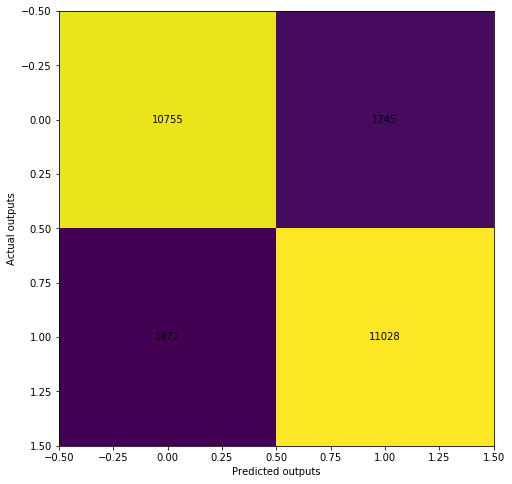

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(conf)
ax.grid(False)
ax.set_xlabel('Predicted outputs', color='black')
ax.set_ylabel('Actual outputs', color='black')
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf[i, j], ha='center', va='center', color='black')
plt.show()